### **Model 2 : Bi-Directional LSTM using GloVe**

In [25]:
!pip install preprocessor
!pip install tensorflow

In [26]:
import pandas as pd
from nltk.tokenize import word_tokenize
from string import punctuation
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import re
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import keras
import numpy as np
from tensorflow.keras.layers import Embedding, SimpleRNN,Input
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.layers import Dense,Dropout
from tensorflow.keras.layers import Embedding, Flatten, Dense,Conv1D,MaxPooling1D
from sklearn import preprocessing
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import itertools
import seaborn as sns
from sklearn.metrics import confusion_matrix
from tensorflow.keras.utils import to_categorical
from collections import Counter
import tensorflow as tf
from tensorflow.keras.layers import LSTM, Bidirectional, Dropout

In [27]:
election = pd.read_csv('/content/election.csv')


First few steps will be the same like the previous model like the cleaning for extra unnecessary elements

In [28]:
def tweet_to_words( raw_review ):
    # Remove non-letters
    letters_only = re.sub("[^a-zA-Z]", " ", raw_review)
    tweet = re.sub('((www\.[^\s]+)|(https?://[^\s]+))', 'URL', letters_only) # remove URLs
    tweet = re.sub('RT', ' ', str(tweet))

    #Convert to lower case, split into individual words
    tweet = letters_only.lower().split()


    return( " ".join(tweet))

In [29]:
election['id'].count()

np.int64(10365)

In [30]:
num_tweets = 10365
vocab_size = 10000
rnn_cell_size = 128

clean_train_tweets = []

for i in range( 0, num_tweets ):
    # Call function for each one, and add the result to the list of
    # clean reviews
    clean_train_tweets.append( tweet_to_words( election["clean_text"][i] ) )

In [31]:
data_inputs =  clean_train_tweets
data_labels = list(election.polarity)

In [32]:
tokenizer = Tokenizer(nb_words=2000)
tokenizer.fit_on_texts(data_inputs)
sequences = tokenizer.texts_to_sequences(data_inputs)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))
max_len = 200
data = pad_sequences(sequences, max_len)

labels = keras.utils.to_categorical(np.asarray(data_labels))
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/text.py:98: UserWarning: The `nb_words` argument in `Tokenizer` has been renamed `num_words`.
  warnings.warn(


Found 8213 unique tokens.
Shape of data tensor: (10365, 200)
Shape of label tensor: (10365, 2)


In [33]:
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]
nb_validation_samples = int(.20 * data.shape[0])

x_train = data[:-nb_validation_samples]
y_train = labels[:-nb_validation_samples]
x_val = data[-nb_validation_samples:]
y_val = labels[-nb_validation_samples:]

### **CREATING A WORD EMBEDDING MATRIX USING GloVe MODEL**

In [35]:
embeddings_index = {}
f = open( r"/content/glove.6B.100d.txt", encoding ="utf-8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [36]:
embedding_matrix = np.zeros((len(word_index) + 1, 100))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

In [38]:
embedding_layer = Embedding(len(word_index) + 1,
                            100,
                            weights=[embedding_matrix],
                            input_length=1000,
                            trainable=False)

### **CREATING THE MODEL REF:ABHISKEK (GITHUB IN CITATIONS)**

In [39]:
sequence_input = Input(shape=(max_len,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)
l_lstm = Bidirectional(LSTM(100))(embedded_sequences)
preds = Dense(2, activation='softmax')(l_lstm)
model = Model(sequence_input, preds)
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['acc'])

In [63]:
history=model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=10, batch_size=50)


Epoch 1/10
166/166 ━━━━━━━━━━━━━━━━━━━━ 99s 598ms/step - acc: 0.9935 - loss: 0.0191 - val_acc: 0.9590 - val_loss: 0.1367
Epoch 2/10
166/166 ━━━━━━━━━━━━━━━━━━━━ 142s 596ms/step - acc: 0.9950 - loss: 0.0152 - val_acc: 0.9711 - val_loss: 0.1226
Epoch 3/10
166/166 ━━━━━━━━━━━━━━━━━━━━ 142s 597ms/step - acc: 0.9931 - loss: 0.0256 - val_acc: 0.9783 - val_loss: 0.0818
Epoch 4/10
166/166 ━━━━━━━━━━━━━━━━━━━━ 142s 599ms/step - acc: 0.9957 - loss: 0.0120 - val_acc: 0.9822 - val_loss: 0.0888
Epoch 5/10
166/166 ━━━━━━━━━━━━━━━━━━━━ 142s 599ms/step - acc: 0.9937 - loss: 0.0294 - val_acc: 0.9788 - val_loss: 0.0956
Epoch 6/10
166/166 ━━━━━━━━━━━━━━━━━━━━ 142s 598ms/step - acc: 0.9974 - loss: 0.0133 - val_acc: 0.9831 - val_loss: 0.0858
Epoch 7/10
166/166 ━━━━━━━━━━━━━━━━━━━━ 143s 602ms/step - acc: 0.9983 - loss: 0.0078 - val_acc: 0.9826 - val_loss: 0.0825
Epoch 8/10
166/166 ━━━━━━━━━━━━━━━━━━━━ 141s 598ms/step - acc: 0.9375 - loss: 0.3643 - val_acc: 0.9677 - val_loss: 0.0846
Epoch 9/10
166/166 ━━━━━━

### **SAVING THE MODEL TO DISK..**

In [64]:
import os
os.makedirs("./SavedModels", exist_ok=True)

# serialize model architecture to JSON
model_json = model.to_json()
with open("./SavedModels/Model_Bidir_LSTM.json", "w") as json_file:
    json_file.write(model_json)

# serialize weights to HDF5
model.save_weights("./SavedModels/Weights_bidir_LSTM.weights.h5")
print("Saved model to disk")



Saved model to disk


### **MODEL LOSS AND ACCURACY**

In [65]:
loss,acc = model.evaluate(x_val,y_val, verbose = 2, batch_size = 50)
print("Validation Loss: %.2f" % (loss))
print("Validation Accuracy: %.2f" % (acc))

42/42 - 9s - 223ms/step - acc: 0.9744 - loss: 0.1108
Validation Loss: 0.11
Validation Accuracy: 0.97


### **MODEL PERFORMANCE**

In [73]:
def plot_modelacc(fit_model):
    with plt.style.context('ggplot'):
        plt.plot(fit_model.history['acc'])
        plt.plot(fit_model.history['val_acc'])
        plt.ylim(0,1)
        plt.title("Model Accuracy")
        plt.xlabel("Epochs")
        plt.ylabel("Accuracy")
        plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

def plot_model_loss(fit_model):
    with plt.style.context('ggplot'):
        plt.plot(fit_model.history['loss'])
        plt.plot(fit_model.history['val_loss'])
        plt.title("Model Loss")
        plt.xlabel("Epochs")
        plt.ylabel("Loss")
        plt.legend(['Train', 'Test'], loc='upper right')
    plt.show()

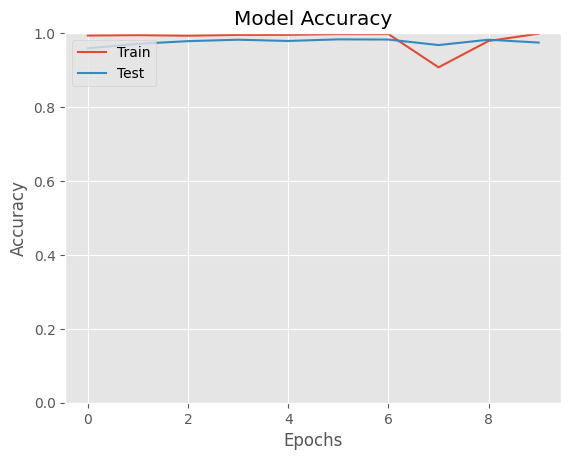

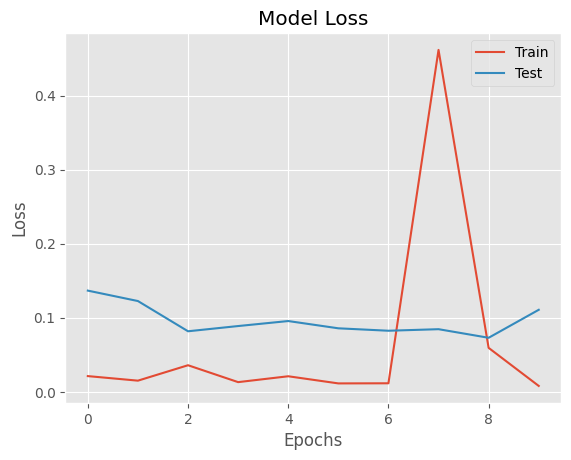

In [74]:
plot_modelacc(history)
plot_model_loss(history)


In [70]:
print(history.history.keys())


dict_keys(['acc', 'loss', 'val_acc', 'val_loss'])


### **CONFUSION MATRIX**

65/65 ━━━━━━━━━━━━━━━━━━━━ 12s 177ms/step
[[1091   42]
 [  11  929]]


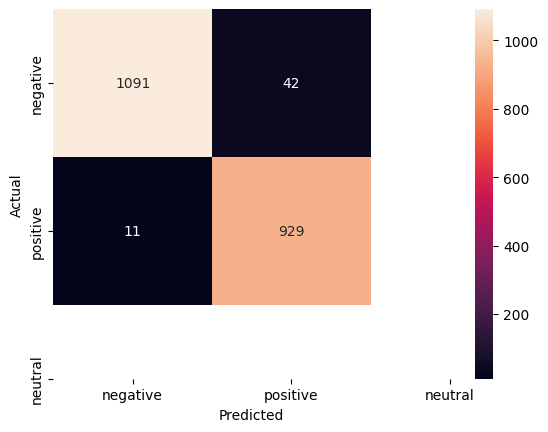

In [75]:
# Predicting the Test set results
y_pred = model.predict(x_val)
# cutoff 0.5
y_pred = (y_pred > 0.5)

y_pred = y_pred.astype(int)


# Confusion matrix
cm = confusion_matrix(y_val.argmax(axis=1), y_pred.argmax(axis=1))
print(cm)

LABELS = ['negative', 'positive','neutral']
sns.heatmap(cm, annot=True, xticklabels=LABELS, yticklabels=LABELS, fmt='g')
xl = plt.xlabel("Predicted")
yl = plt.ylabel("Actual")

True Positives: 929(Predicted True and True in reality)<br>
True Negative: 1091(Predicted False and False in realtity)<br>
False Positive: 42 (Predicted Positve but Negative in reality)<br>
False Negative: 11 (Predicted Negative but Positive in reality)